# Bone Fracture Classification using CNN
This notebook demonstrates a binary classification model to detect bone fractures from X-ray images.

In [1]:
# Import Required Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')
from PIL import Image, ImageFile
# Allow truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.1


## Setup Data Directories

In [2]:
# Define data directories
data_dir = Path('BoneFractureDataset')
train_dir = data_dir / 'training'
test_dir = data_dir / 'testing'
val_dir = data_dir / 'validation'

# Image parameters
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

print(f"Training directory: {train_dir}")
print(f"Testing directory: {test_dir}")
print(f"Validation directory: {val_dir}")

Training directory: BoneFractureDataset\training
Testing directory: BoneFractureDataset\testing
Validation directory: BoneFractureDataset\validation


## Load Datasets

In [3]:
# Load datasets using tf.keras
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 7091 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 1772 files belonging to 2 classes.


In [4]:
# Get class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Class names: ['fractured', 'not_fractured']


## Visualize Sample Images

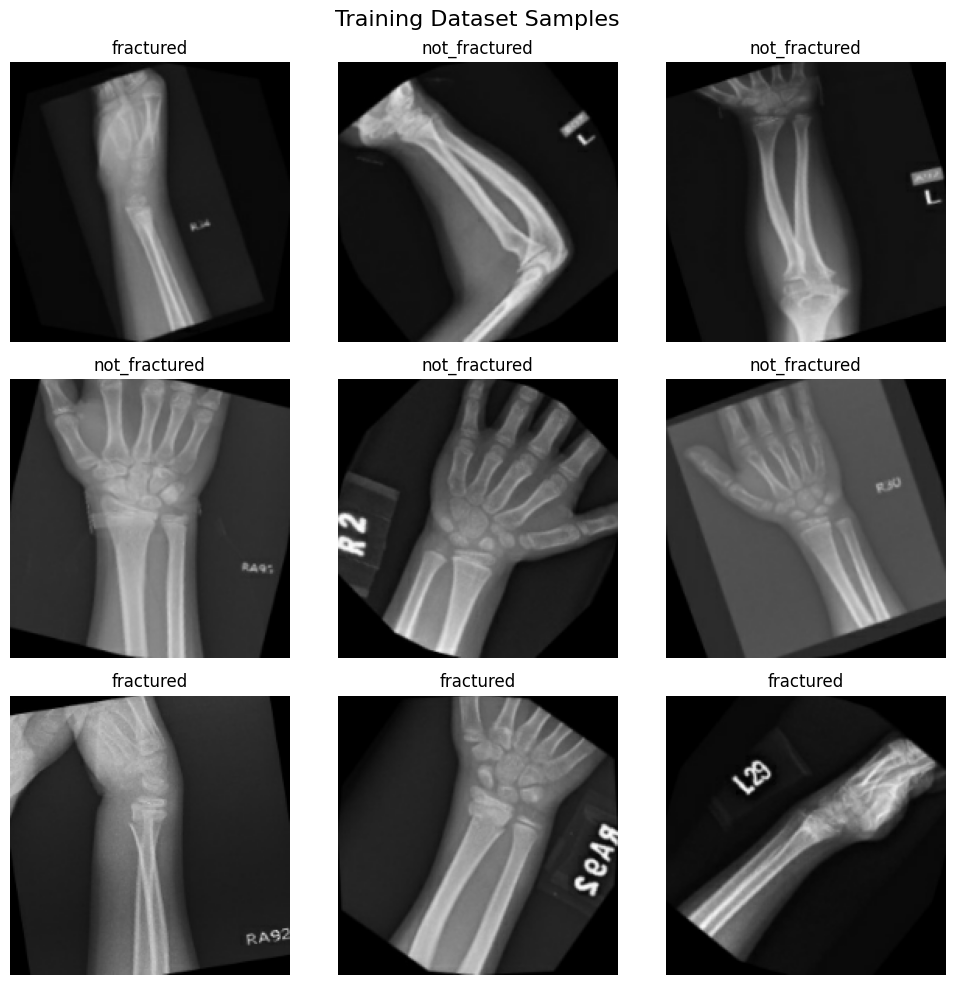

In [5]:
# Function to display sample images
def show_images(dataset, title):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(min(9, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display training samples
show_images(train_ds, 'Training Dataset Samples')

## Analyze Class Distribution

In [6]:
# Functions to count and visualize class distribution
def count_classes(dataset_path, class_name):
    class_path = Path(dataset_path) / class_name
    return len(list(class_path.glob("*")))

def create_class_counts_df(dataset_path, class_names):
    counts = {'class': [], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset_path, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    plt.figure(figsize=(8, 5))
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title, fontsize=14)
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i, v in enumerate(df['count']):
        plt.text(i, v + 5, str(v), ha='center', fontsize=12)
    plt.tight_layout()
    plt.show()

Training Set Distribution:
           class  count
0      fractured   3584
1  not_fractured   3507


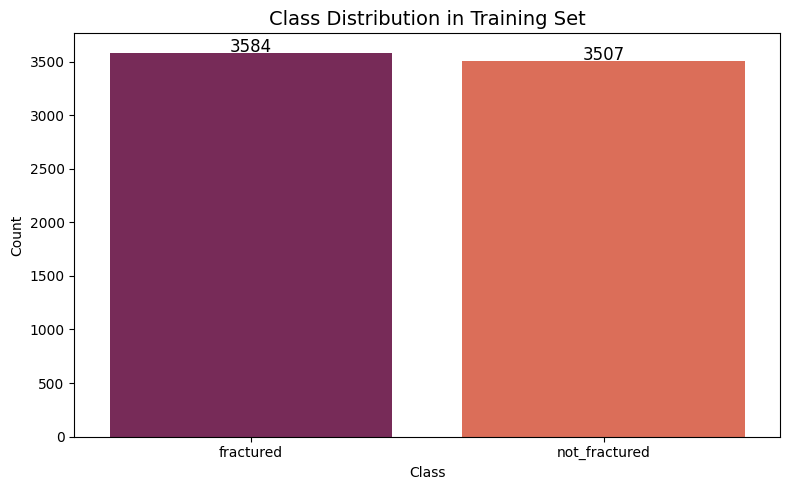

In [7]:
# Plot class distribution for training set
train_df = create_class_counts_df(train_dir, class_names)
print("Training Set Distribution:")
print(train_df)
plot_class_distribution(train_df, 'Class Distribution in Training Set', palette='rocket')

Testing Set Distribution:
           class  count
0      fractured    360
1  not_fractured    240


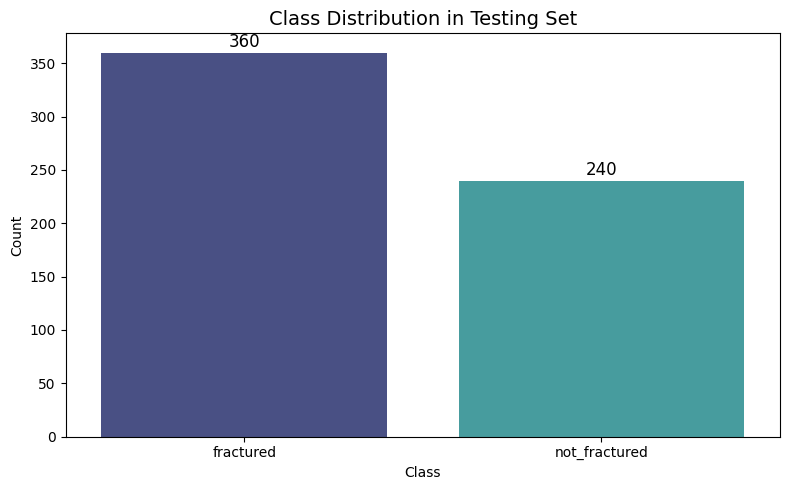

In [8]:
# Plot class distribution for testing set
test_df = create_class_counts_df(test_dir, class_names)
print("Testing Set Distribution:")
print(test_df)
plot_class_distribution(test_df, 'Class Distribution in Testing Set', palette='mako')

Validation Set Distribution:
           class  count
0      fractured    896
1  not_fractured    876


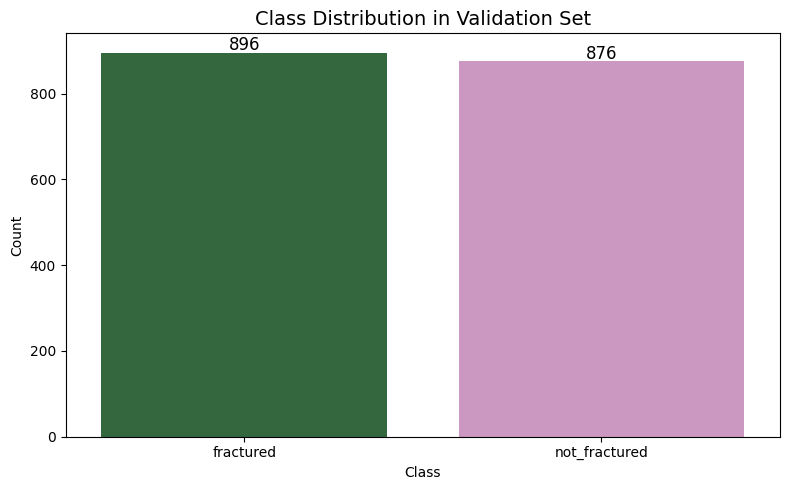

In [9]:
# Plot class distribution for validation set
val_df = create_class_counts_df(val_dir, class_names)
print("Validation Set Distribution:")
print(val_df)
plot_class_distribution(val_df, 'Class Distribution in Validation Set', palette='cubehelix')

## Data Augmentation

In [10]:
# Create ImageDataGenerators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Only rescaling for test and validation
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Create data generators
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Print class indices
print(f"Class indices: {training_set.class_indices}")

Found 7091 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 1772 images belonging to 2 classes.
Class indices: {'fractured': 0, 'not_fractured': 1}


## Build CNN Model

In [12]:
# Build the CNN model
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Fourth Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

In [13]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


## Train the Model

In [14]:
# Define callbacks for better training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_fracture_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [15]:
# Train the model
EPOCHS = 15

history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/15
 38/222 [====>.........................] - ETA: 3:21 - loss: 0.6850 - accuracy: 0.5543

KeyboardInterrupt: 

## Evaluate the Model

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_set)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

## Plot Training History

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Confusion Matrix and Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
test_set.reset()
y_pred_probs = model.predict(test_set)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_set.classes

# Get class labels
class_labels = list(test_set.class_indices.keys())

# Classification report
print("Classification Report:")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Save the Model

In [ ]:
# Save the model
model.save('fracture_classification_model.keras')
print("Model saved as 'fracture_classification_model.keras'")

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('fracture_classification_model.keras')
print("Model loaded successfully!")

## Predict on Custom Images

In [ ]:
# Function to preprocess and predict on a custom image
def load_preprocessed_image(image_path, img_height=180, img_width=180):
    """Load and preprocess an image for prediction."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_width, img_height))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(model, image_path, class_names=['fractured', 'not_fractured']):
    """Predict the class of a single image."""
    preprocessed_img = load_preprocessed_image(image_path)
    prediction = model.predict(preprocessed_img, verbose=0)
    predicted_class = (prediction > 0.5).astype(int)[0][0]
    confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]
    
    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()
    
    return class_names[predicted_class], confidence

print("Prediction functions defined successfully!")

In [ ]:
# Example: Predict on a sample image from testing set
# Get a sample image path from the testing folder
sample_fractured = list(Path(test_dir / 'fractured').glob('*'))[0]
sample_not_fractured = list(Path(test_dir / 'not_fractured').glob('*'))[0]

print("Testing on a fractured sample:")
pred_class, conf = predict_image(loaded_model, sample_fractured)
print(f"Prediction: {pred_class}, Confidence: {conf:.2%}\n")

In [ ]:
print("Testing on a not fractured sample:")
pred_class, conf = predict_image(loaded_model, sample_not_fractured)
print(f"Prediction: {pred_class}, Confidence: {conf:.2%}")

## Calculate Precision on a Folder

In [ ]:
def calculate_folder_metrics(folder_path, model, expected_class, img_height=180, img_width=180):
    """
    Calculate metrics for all images in a folder.
    
    Args:
        folder_path: Path to the folder containing images
        model: Trained model
        expected_class: 0 for 'fractured', 1 for 'not_fractured'
        img_height, img_width: Image dimensions
    
    Returns:
        Dictionary with metrics
    """
    class_names = ['fractured', 'not_fractured']
    correct = 0
    incorrect = 0
    total_images = 0
    
    folder = Path(folder_path)
    image_files = list(folder.glob('*.png')) + list(folder.glob('*.jpg')) + list(folder.glob('*.jpeg'))
    
    for image_file in image_files:
        try:
            preprocessed_img = load_preprocessed_image(image_file, img_height, img_width)
            prediction = model.predict(preprocessed_img, verbose=0)
            predicted_class = (prediction > 0.5).astype(int)[0][0]
            
            total_images += 1
            if predicted_class == expected_class:
                correct += 1
            else:
                incorrect += 1
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
            continue
    
    accuracy = correct / total_images if total_images > 0 else 0
    
    print(f"\n{'='*50}")
    print(f"Folder: {folder_path}")
    print(f"Expected class: {class_names[expected_class]}")
    print(f"{'='*50}")
    print(f"Total images: {total_images}")
    print(f"Correct predictions: {correct}")
    print(f"Incorrect predictions: {incorrect}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"{'='*50}")
    
    return {
        'total': total_images,
        'correct': correct,
        'incorrect': incorrect,
        'accuracy': accuracy
    }

print("Folder metrics function defined successfully!")

In [ ]:
# Calculate metrics on the testing folders
print("Evaluating on testing/fractured folder:")
fractured_metrics = calculate_folder_metrics(
    test_dir / 'fractured', 
    loaded_model, 
    expected_class=0  # 0 for fractured
)

print("\nEvaluating on testing/not_fractured folder:")
not_fractured_metrics = calculate_folder_metrics(
    test_dir / 'not_fractured', 
    loaded_model, 
    expected_class=1  # 1 for not_fractured
)

## Visualize Predictions on Multiple Images

In [ ]:
# Visualize predictions on multiple test images
def visualize_predictions(model, test_dir, num_images=12):
    """Display predictions on multiple test images."""
    class_names = ['fractured', 'not_fractured']
    
    # Get images from both classes
    fractured_images = list(Path(test_dir / 'fractured').glob('*'))[:num_images//2]
    not_fractured_images = list(Path(test_dir / 'not_fractured').glob('*'))[:num_images//2]
    all_images = fractured_images + not_fractured_images
    
    # Determine grid size
    cols = 4
    rows = (len(all_images) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    axes = axes.flatten()
    
    for idx, img_path in enumerate(all_images):
        # Load and preprocess
        preprocessed_img = load_preprocessed_image(img_path)
        prediction = model.predict(preprocessed_img, verbose=0)
        predicted_class = (prediction > 0.5).astype(int)[0][0]
        confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]
        
        # Get true label from folder name
        true_label = img_path.parent.name
        is_correct = class_names[predicted_class] == true_label
        
        # Display
        img = Image.open(img_path)
        axes[idx].imshow(img)
        color = 'green' if is_correct else 'red'
        axes[idx].set_title(f"True: {true_label}\nPred: {class_names[predicted_class]}\nConf: {confidence:.2%}", 
                          color=color, fontsize=10)
        axes[idx].axis('off')
    
    # Hide empty subplots
    for idx in range(len(all_images), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Model Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_predictions(loaded_model, test_dir, num_images=12)

## Summary
This notebook trained a CNN model for bone fracture classification with:
- Data augmentation for better generalization
- Early stopping and learning rate reduction callbacks
- Comprehensive evaluation metrics including confusion matrix
- Custom image prediction functionality

# Model Comparison: CNN vs ANN vs SVM vs Random Forest
Now let's train and compare multiple models on the same dataset.

In [ ]:
# Prepare data for traditional ML models (SVM, Random Forest)
# We need to flatten the images into 1D arrays

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Function to extract features from ImageDataGenerator
def extract_features_from_generator(generator, num_samples):
    """Extract features and labels from a generator."""
    features = []
    labels = []
    samples_collected = 0
    
    generator.reset()
    
    for batch_images, batch_labels in generator:
        for i in range(len(batch_images)):
            if samples_collected >= num_samples:
                break
            # Flatten the image
            features.append(batch_images[i].flatten())
            labels.append(batch_labels[i])
            samples_collected += 1
        if samples_collected >= num_samples:
            break
    
    return np.array(features), np.array(labels)

print("Feature extraction function defined!")

In [ ]:
# Extract features from training and test sets
# Using smaller image size for traditional ML models to reduce memory usage
print("Extracting features from training set...")
X_train, y_train = extract_features_from_generator(training_set, training_set.samples)
print(f"Training features shape: {X_train.shape}")

print("\nExtracting features from test set...")
X_test, y_test = extract_features_from_generator(test_set, test_set.samples)
print(f"Test features shape: {X_test.shape}")

print("\nExtracting features from validation set...")
X_val, y_val = extract_features_from_generator(val_set, val_set.samples)
print(f"Validation features shape: {X_val.shape}")

## Model 1: CNN (Convolutional Neural Network) - Already Trained
The CNN model was trained above. Let's store its metrics for comparison.

In [ ]:
# Store CNN metrics for comparison
# Get CNN predictions on test set
test_set.reset()
cnn_start_time = time.time()
cnn_predictions = model.predict(test_set, verbose=0)
cnn_pred_time = time.time() - cnn_start_time
cnn_y_pred = (cnn_predictions > 0.5).astype(int).flatten()
cnn_y_true = test_set.classes

# Calculate CNN metrics
cnn_accuracy = accuracy_score(cnn_y_true, cnn_y_pred)
cnn_precision = precision_score(cnn_y_true, cnn_y_pred)
cnn_recall = recall_score(cnn_y_true, cnn_y_pred)
cnn_f1 = f1_score(cnn_y_true, cnn_y_pred)

print("CNN Model Metrics:")
print(f"  Accuracy:  {cnn_accuracy:.4f}")
print(f"  Precision: {cnn_precision:.4f}")
print(f"  Recall:    {cnn_recall:.4f}")
print(f"  F1-Score:  {cnn_f1:.4f}")

## Model 2: ANN (Artificial Neural Network)
A simple fully connected neural network without convolutional layers.

In [ ]:
# Build ANN Model (Fully Connected Neural Network)
ann_model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT * IMG_WIDTH * 3,)),
    
    # Hidden layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')
])

ann_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

ann_model.summary()

In [ ]:
# Train ANN Model
ann_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Training ANN Model...")
ann_start_time = time.time()

ann_history = ann_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[ann_early_stopping],
    verbose=1
)

ann_train_time = time.time() - ann_start_time
print(f"\nANN Training completed in {ann_train_time:.2f} seconds")

In [ ]:
# Evaluate ANN Model
ann_predictions = ann_model.predict(X_test, verbose=0)
ann_y_pred = (ann_predictions > 0.5).astype(int).flatten()

# Calculate ANN metrics
ann_accuracy = accuracy_score(y_test, ann_y_pred)
ann_precision = precision_score(y_test, ann_y_pred)
ann_recall = recall_score(y_test, ann_y_pred)
ann_f1 = f1_score(y_test, ann_y_pred)

print("ANN Model Metrics:")
print(f"  Accuracy:  {ann_accuracy:.4f}")
print(f"  Precision: {ann_precision:.4f}")
print(f"  Recall:    {ann_recall:.4f}")
print(f"  F1-Score:  {ann_f1:.4f}")

## Model 3: SVM (Support Vector Machine)
A traditional machine learning classifier with RBF kernel.

In [ ]:
# For SVM, we'll use PCA to reduce dimensionality (faster training)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensions
print("Applying PCA for dimensionality reduction...")
n_components = min(500, X_train_scaled.shape[0], X_train_scaled.shape[1])
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Reduced features from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]} dimensions")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

In [ ]:
# Train SVM Model
print("Training SVM Model (this may take a while)...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

svm_start_time = time.time()
svm_model.fit(X_train_pca, y_train)
svm_train_time = time.time() - svm_start_time

print(f"SVM Training completed in {svm_train_time:.2f} seconds")

In [ ]:
# Evaluate SVM Model
svm_y_pred = svm_model.predict(X_test_pca)

# Calculate SVM metrics
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision = precision_score(y_test, svm_y_pred)
svm_recall = recall_score(y_test, svm_y_pred)
svm_f1 = f1_score(y_test, svm_y_pred)

print("SVM Model Metrics:")
print(f"  Accuracy:  {svm_accuracy:.4f}")
print(f"  Precision: {svm_precision:.4f}")
print(f"  Recall:    {svm_recall:.4f}")
print(f"  F1-Score:  {svm_f1:.4f}")

## Model 4: Random Forest
An ensemble learning method using multiple decision trees.

In [ ]:
# Train Random Forest Model
print("Training Random Forest Model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_start_time = time.time()
rf_model.fit(X_train_pca, y_train)
rf_train_time = time.time() - rf_start_time

print(f"\nRandom Forest Training completed in {rf_train_time:.2f} seconds")

In [ ]:
# Evaluate Random Forest Model
rf_y_pred = rf_model.predict(X_test_pca)

# Calculate Random Forest metrics
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)

print("Random Forest Model Metrics:")
print(f"  Accuracy:  {rf_accuracy:.4f}")
print(f"  Precision: {rf_precision:.4f}")
print(f"  Recall:    {rf_recall:.4f}")
print(f"  F1-Score:  {rf_f1:.4f}")

## Model Comparison Results
Let's compare all four models side by side.

In [ ]:
# Create comparison DataFrame
comparison_data = {
    'Model': ['CNN', 'ANN', 'SVM', 'Random Forest'],
    'Accuracy': [cnn_accuracy, ann_accuracy, svm_accuracy, rf_accuracy],
    'Precision': [cnn_precision, ann_precision, svm_precision, rf_precision],
    'Recall': [cnn_recall, ann_recall, svm_recall, rf_recall],
    'F1-Score': [cnn_f1, ann_f1, svm_f1, rf_f1]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

# Display the comparison table
print("=" * 70)
print("MODEL COMPARISON RESULTS")
print("=" * 70)
print(comparison_df.round(4).to_string())
print("=" * 70)

# Highlight the best model for each metric
print("\nBest Model by Metric:")
print(f"  Best Accuracy:  {comparison_df['Accuracy'].idxmax()} ({comparison_df['Accuracy'].max():.4f})")
print(f"  Best Precision: {comparison_df['Precision'].idxmax()} ({comparison_df['Precision'].max():.4f})")
print(f"  Best Recall:    {comparison_df['Recall'].idxmax()} ({comparison_df['Recall'].max():.4f})")
print(f"  Best F1-Score:  {comparison_df['F1-Score'].idxmax()} ({comparison_df['F1-Score'].max():.4f})")

In [ ]:
# Visualize comparison - Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(comparison_df.index, comparison_df[metric], color=colors, edgecolor='black', linewidth=1.2)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1.1)
    ax.axhline(y=comparison_df[metric].max(), color='red', linestyle='--', alpha=0.5, label='Best')
    
    # Add value labels on bars
    for bar, val in zip(bars, comparison_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Radar Chart for Model Comparison
from math import pi

# Prepare data for radar chart
categories = list(comparison_df.columns)
N = len(categories)

# Create angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors_radar = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
models = comparison_df.index.tolist()

for idx, model in enumerate(models):
    values = comparison_df.loc[model].values.flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.25, color=colors_radar[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

In [ ]:
# Confusion Matrices for All Models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Get predictions for each model
predictions = {
    'CNN': cnn_y_pred,
    'ANN': ann_y_pred,
    'SVM': svm_y_pred,
    'Random Forest': rf_y_pred
}

true_labels = {
    'CNN': cnn_y_true,
    'ANN': y_test,
    'SVM': y_test,
    'Random Forest': y_test
}

class_labels = ['fractured', 'not_fractured']

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(true_labels[model_name], y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title(f'{model_name} Confusion Matrix', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Heatmap of all metrics
plt.figure(figsize=(10, 6))
sns.heatmap(comparison_df, annot=True, cmap='RdYlGn', fmt='.4f', 
            linewidths=0.5, vmin=0, vmax=1, 
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Model Metrics Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.tight_layout()
plt.show()

## Final Comparison Summary

In [ ]:
# Final Summary with Rankings
print("=" * 80)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 80)

# Calculate average score for each model
comparison_df['Average Score'] = comparison_df.mean(axis=1)

# Rank models
comparison_df_sorted = comparison_df.sort_values('Average Score', ascending=False)

print("\nModel Rankings (by Average Score):")
print("-" * 50)
for rank, (model, row) in enumerate(comparison_df_sorted.iterrows(), 1):
    print(f"  #{rank}: {model}")
    print(f"       Accuracy:  {row['Accuracy']:.4f}")
    print(f"       Precision: {row['Precision']:.4f}")
    print(f"       Recall:    {row['Recall']:.4f}")
    print(f"       F1-Score:  {row['F1-Score']:.4f}")
    print(f"       Average:   {row['Average Score']:.4f}")
    print()

# Winner announcement
winner = comparison_df_sorted.index[0]
print("=" * 80)
print(f"🏆 BEST MODEL: {winner}")
print(f"   Average Score: {comparison_df_sorted.loc[winner, 'Average Score']:.4f}")
print("=" * 80)

# Detailed insights
print("\n📊 KEY INSIGHTS:")
print("-" * 50)
print(f"• CNN excels at learning spatial features from images")
print(f"• ANN is simpler but may lose spatial information")
print(f"• SVM works well with PCA-reduced features")
print(f"• Random Forest is robust but may need feature engineering")
print("-" * 50)

In [ ]:
# Save comparison results to CSV
comparison_df_sorted.to_csv('model_comparison_results.csv')
print("Comparison results saved to 'model_comparison_results.csv'")

# Display final comparison table with styling
print("\n📋 COMPLETE COMPARISON TABLE:")
print(comparison_df_sorted.round(4).to_string())

## Conclusion

### Model Comparison Summary:

| Model | Description | Pros | Cons |
|-------|-------------|------|------|
| **CNN** | Convolutional Neural Network | Best for image data, learns spatial features | Requires more data and computation |
| **ANN** | Artificial Neural Network | Simple architecture, fast training | Loses spatial information from images |
| **SVM** | Support Vector Machine | Works well with smaller datasets | Requires feature engineering (PCA) |
| **Random Forest** | Ensemble of Decision Trees | Robust, handles non-linear data | May require feature engineering |

### Recommendations:
- For **image classification tasks**, CNN is typically the best choice
- For **smaller datasets**, SVM or Random Forest may perform comparably
- **ANN** provides a good baseline but loses spatial information
- Consider **ensemble methods** combining multiple models for better results